In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 14-25-52.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 14-25-52_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_05.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752197279.917964 23335142 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752197279.924807 23336048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752197279.931599 23336049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752197291.768054 23336047 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 10819
Frames with at least 1 hand detected: 9715
Detection rate: 89.80%


In [2]:
df = pd.read_csv("hand_landmarks_05.csv")

print("Shape:", df.shape)
df

Shape: (271719, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
271714,10818,180.316667,Right,16,NaN,NaN,NaN,0
271715,10818,180.316667,Right,17,NaN,NaN,NaN,0
271716,10818,180.316667,Right,18,NaN,NaN,NaN,0
271717,10818,180.316667,Right,19,NaN,NaN,NaN,0


In [3]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [4]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,63,1.050,Right,1,0.545396,0.556310,0.564390,0.565508,0.562974,0.572470,...,-0.010653,-0.012480,-0.007209,-0.008456,-0.008761,-0.009201,-0.008211,-0.007739,-0.005836,-0.004647
1,64,1.067,Right,1,0.576775,0.587427,0.596074,0.598035,0.595805,0.603056,...,-0.020491,-0.022738,-0.012713,-0.015929,-0.017131,-0.018028,-0.012860,-0.014536,-0.014111,-0.013815
2,65,1.083,Right,1,0.572197,0.582002,0.591232,0.595138,0.595865,0.599915,...,-0.022836,-0.025580,-0.013297,-0.017417,-0.020175,-0.022035,-0.013661,-0.016803,-0.018240,-0.019181
3,66,1.100,Right,1,0.610737,0.619463,0.625736,0.627187,0.626846,0.635991,...,-0.025616,-0.028367,-0.015428,-0.019770,-0.021864,-0.023397,-0.015236,-0.017948,-0.018315,-0.018612
4,67,1.117,Right,1,0.604965,0.614296,0.622353,0.625762,0.626436,0.632389,...,-0.025779,-0.028835,-0.014692,-0.019218,-0.022246,-0.024379,-0.014633,-0.018045,-0.019675,-0.020826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10593,10687,178.117,Right,1,0.290385,0.328849,0.348210,0.357649,0.358907,0.311487,...,0.047943,0.048710,0.028293,0.042575,0.047997,0.049146,0.029953,0.042440,0.050214,0.054787
10594,10688,178.133,Right,1,0.290911,0.329515,0.347844,0.356802,0.358914,0.309855,...,0.068670,0.070347,0.040294,0.061822,0.069176,0.070713,0.042990,0.060684,0.070124,0.075632
10595,10689,178.150,Right,1,0.288167,0.327408,0.346916,0.356440,0.358373,0.309888,...,0.059515,0.060933,0.035477,0.054451,0.060767,0.062155,0.037776,0.054498,0.063949,0.069611
10596,10690,178.167,Right,1,0.288009,0.327641,0.346655,0.358292,0.360911,0.310859,...,0.064161,0.069623,0.036538,0.055595,0.067853,0.074362,0.038942,0.057407,0.070264,0.078624


In [5]:
df2 = pd.read_csv("hand_lable_05.csv")

print("Shape:", df.shape)
df2

Shape: (271719, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,other,NaN,START,7.150,D:/Data Science/UOB/DS_project/Full Study/05/2...,429,NaN,NaN
1,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,other,NaN,STOP,8.667,D:/Data Science/UOB/DS_project/Full Study/05/2...,520,NaN,NaN
2,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,lift,NaN,START,8.683,D:/Data Science/UOB/DS_project/Full Study/05/2...,521,NaN,NaN
3,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,lift,NaN,STOP,9.283,D:/Data Science/UOB/DS_project/Full Study/05/2...,557,NaN,NaN
4,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,hold,NaN,START,9.300,D:/Data Science/UOB/DS_project/Full Study/05/2...,558,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,hold,NaN,STOP,173.483,D:/Data Science/UOB/DS_project/Full Study/05/2...,10409,NaN,NaN
224,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,place,NaN,START,173.500,D:/Data Science/UOB/DS_project/Full Study/05/2...,10410,NaN,NaN
225,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,place,NaN,STOP,174.900,D:/Data Science/UOB/DS_project/Full Study/05/2...,10494,NaN,NaN
226,5,2025-07-08 21:07:04.416,NaN,168.533,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,180.317,60.0,NaN,other,NaN,START,174.917,D:/Data Science/UOB/DS_project/Full Study/05/2...,10495,NaN,NaN


In [6]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,7.150,8.667,429,520
1,lift,8.683,9.283,521,557
2,hold,9.300,25.267,558,1516
3,press,25.283,25.683,1517,1541
4,hold,25.700,26.750,1542,1605
...,...,...,...,...,...
109,adjust,162.150,166.733,9729,10004
110,rotate,166.750,172.117,10005,10327
111,hold,172.133,173.483,10328,10409
112,place,173.500,174.900,10410,10494


In [7]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_21263/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,63,1.050,Right,1,0.545396,0.556310,0.564390,0.565508,0.562974,0.572470,...,-0.012480,-0.007209,-0.008456,-0.008761,-0.009201,-0.008211,-0.007739,-0.005836,-0.004647,NaN
1,64,1.067,Right,1,0.576775,0.587427,0.596074,0.598035,0.595805,0.603056,...,-0.022738,-0.012713,-0.015929,-0.017131,-0.018028,-0.012860,-0.014536,-0.014111,-0.013815,NaN
2,65,1.083,Right,1,0.572197,0.582002,0.591232,0.595138,0.595865,0.599915,...,-0.025580,-0.013297,-0.017417,-0.020175,-0.022035,-0.013661,-0.016803,-0.018240,-0.019181,NaN
3,66,1.100,Right,1,0.610737,0.619463,0.625736,0.627187,0.626846,0.635991,...,-0.028367,-0.015428,-0.019770,-0.021864,-0.023397,-0.015236,-0.017948,-0.018315,-0.018612,NaN
4,67,1.117,Right,1,0.604965,0.614296,0.622353,0.625762,0.626436,0.632389,...,-0.028835,-0.014692,-0.019218,-0.022246,-0.024379,-0.014633,-0.018045,-0.019675,-0.020826,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10593,10687,178.117,Right,1,0.290385,0.328849,0.348210,0.357649,0.358907,0.311487,...,0.048710,0.028293,0.042575,0.047997,0.049146,0.029953,0.042440,0.050214,0.054787,NaN
10594,10688,178.133,Right,1,0.290911,0.329515,0.347844,0.356802,0.358914,0.309855,...,0.070347,0.040294,0.061822,0.069176,0.070713,0.042990,0.060684,0.070124,0.075632,NaN
10595,10689,178.150,Right,1,0.288167,0.327408,0.346916,0.356440,0.358373,0.309888,...,0.060933,0.035477,0.054451,0.060767,0.062155,0.037776,0.054498,0.063949,0.069611,NaN
10596,10690,178.167,Right,1,0.288009,0.327641,0.346655,0.358292,0.360911,0.310859,...,0.069623,0.036538,0.055595,0.067853,0.074362,0.038942,0.057407,0.070264,0.078624,NaN


In [8]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    3346
hold      2383
adjust    1808
NaN        795
other      741
place      660
press      627
lift       238
Name: count, dtype: int64


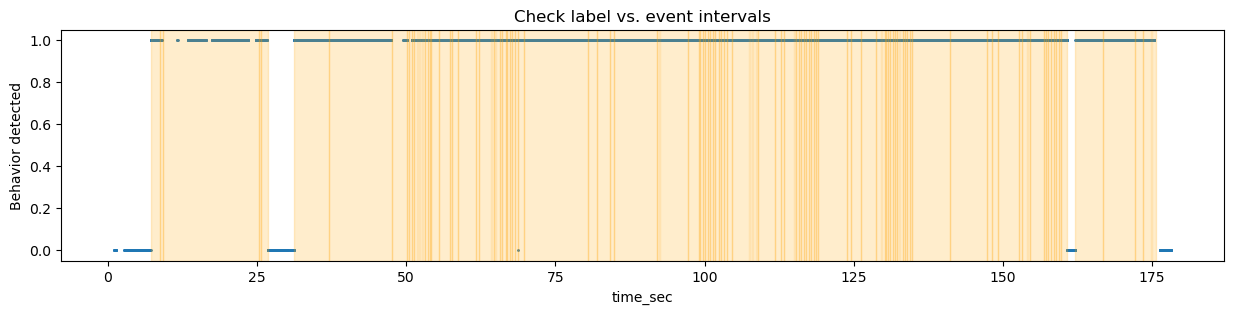

In [9]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [10]:
df_wide[(df_wide['time_sec'] <= 8.683)][['time_sec', 'behavior']]

,time_sec,behavior
0,1.050,NaN
1,1.067,NaN
2,1.083,NaN
3,1.100,NaN
4,1.117,NaN
...,...,...
394,8.633,other
395,8.650,other
396,8.650,other
397,8.667,other


In [11]:
df_wide[(df_wide['time_sec'] <= 103.2)][['time_sec', 'behavior']]

,time_sec,behavior
0,1.050,NaN
1,1.067,NaN
2,1.083,NaN
3,1.100,NaN
4,1.117,NaN
...,...,...
5540,103.133,hold
5541,103.150,hold
5542,103.167,hold
5543,103.183,hold


In [12]:
df_wide[(df_wide['time_sec'] <= 166.75)][['time_sec', 'behavior']]

,time_sec,behavior
0,1.050,NaN
1,1.067,NaN
2,1.083,NaN
3,1.100,NaN
4,1.117,NaN
...,...,...
9799,166.667,adjust
9800,166.683,adjust
9801,166.700,adjust
9802,166.717,adjust


In [13]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
303,429,7.150,Right,1,0.379958,0.419680,0.456384,0.486729,0.512110,0.396960,...,-0.043557,0.005926,0.000820,-0.008029,-0.013645,0.026123,0.023256,0.019897,0.018194,other
304,430,7.167,Right,1,0.378886,0.419476,0.455771,0.485891,0.511683,0.395255,...,-0.024701,0.009945,0.009892,0.005114,0.001656,0.028974,0.029519,0.027152,0.025814,other
305,431,7.183,Right,1,0.377534,0.419607,0.453517,0.483251,0.508968,0.390350,...,-0.034948,0.006735,0.003091,-0.002341,-0.004563,0.030193,0.029302,0.026076,0.025189,other
306,432,7.200,Right,1,0.381360,0.421871,0.455191,0.483459,0.507056,0.391719,...,-0.033551,0.003994,0.001325,-0.003044,-0.004877,0.025595,0.024903,0.022175,0.021475,other
307,433,7.217,Right,1,0.379799,0.422255,0.455082,0.483871,0.507308,0.390377,...,-0.032845,0.003741,0.001077,-0.002736,-0.004079,0.025213,0.024976,0.022537,0.022051,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,10519,175.317,Right,1,0.333235,0.360886,0.383257,0.399695,0.405008,0.290842,...,-0.099839,-0.063974,-0.084091,-0.073423,-0.065590,-0.049523,-0.068140,-0.065564,-0.060832,other
10482,10520,175.333,Right,1,0.320583,0.352801,0.376192,0.387437,0.393935,0.296896,...,-0.081594,-0.053808,-0.073084,-0.067755,-0.062642,-0.042765,-0.060216,-0.060959,-0.058777,other
10483,10521,175.350,Right,1,0.313587,0.343512,0.366015,0.379062,0.394304,0.291604,...,-0.072562,-0.047944,-0.067927,-0.061077,-0.053176,-0.036560,-0.054414,-0.054764,-0.051195,other
10484,10522,175.367,Right,1,0.299511,0.336735,0.365703,0.379383,0.391640,0.295782,...,-0.084076,-0.051280,-0.070528,-0.064758,-0.058117,-0.034331,-0.051325,-0.052275,-0.049463,other


In [14]:
df_wide['dataset_id'] = '05'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_21263/2810222856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '05'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
303,05,429,7.150,Right,1,0.379958,0.419680,0.456384,0.486729,0.512110,...,-0.043557,0.005926,0.000820,-0.008029,-0.013645,0.026123,0.023256,0.019897,0.018194,other
304,05,430,7.167,Right,1,0.378886,0.419476,0.455771,0.485891,0.511683,...,-0.024701,0.009945,0.009892,0.005114,0.001656,0.028974,0.029519,0.027152,0.025814,other
305,05,431,7.183,Right,1,0.377534,0.419607,0.453517,0.483251,0.508968,...,-0.034948,0.006735,0.003091,-0.002341,-0.004563,0.030193,0.029302,0.026076,0.025189,other
306,05,432,7.200,Right,1,0.381360,0.421871,0.455191,0.483459,0.507056,...,-0.033551,0.003994,0.001325,-0.003044,-0.004877,0.025595,0.024903,0.022175,0.021475,other
307,05,433,7.217,Right,1,0.379799,0.422255,0.455082,0.483871,0.507308,...,-0.032845,0.003741,0.001077,-0.002736,-0.004079,0.025213,0.024976,0.022537,0.022051,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,05,10519,175.317,Right,1,0.333235,0.360886,0.383257,0.399695,0.405008,...,-0.099839,-0.063974,-0.084091,-0.073423,-0.065590,-0.049523,-0.068140,-0.065564,-0.060832,other
10482,05,10520,175.333,Right,1,0.320583,0.352801,0.376192,0.387437,0.393935,...,-0.081594,-0.053808,-0.073084,-0.067755,-0.062642,-0.042765,-0.060216,-0.060959,-0.058777,other
10483,05,10521,175.350,Right,1,0.313587,0.343512,0.366015,0.379062,0.394304,...,-0.072562,-0.047944,-0.067927,-0.061077,-0.053176,-0.036560,-0.054414,-0.054764,-0.051195,other
10484,05,10522,175.367,Right,1,0.299511,0.336735,0.365703,0.379383,0.391640,...,-0.084076,-0.051280,-0.070528,-0.064758,-0.058117,-0.034331,-0.051325,-0.052275,-0.049463,other


In [15]:
df_wide.to_csv("handlandmark_wide_05.csv", index=False)